In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install latest pre-release version of bigdl-chronos 
# Installing bigdl-chronos from pip will automatically install pyspark, bigdl, and their dependencies.
#!pip install --pre --upgrade bigdl-chronos[all]
!pip install bigdl-chronos[all]==2.0.0
!pip install torchmetrics==0.7.3
!pip uninstall -y torchtext
!pip install prophet
exit() # restart the runtime to refresh installed pkg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 222 kB 36.0 MB/s 
     |████████████████████████████████| 9.9 MB 62.0 MB/s 
     |████████████████████████████████| 2.2 MB 64.7 MB/s 
     |████████████████████████████████| 23.9 MB 2.0 MB/s 
     |████████████████████████████████| 101.0 MB 44 kB/s 
     |████████████████████████████████| 71.0 MB 152 kB/s 
     |████████████████████████████████| 35.4 MB 1.2 MB/s 
     |████████████████████████████████| 218.4 MB 52 kB/s 
     |████████████████████████████████| 85 kB 4.8 MB/s 
     |████████████████████████████████| 1.1 MB 58.2 MB/s 
     |████████████████████████████████| 65 kB 4.4 MB/s 
     |████████████████████████████████| 57.6 MB 1.1 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 144 kB 77.7 MB/s 
     |████████████████████████████████| 271 kB 78.4 MB/s 
     |███████████████████████████████

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("/content/drive/MyDrive/Courses/Khoá luận tốt nghiệp/Dataset/final_data_6.csv")
df['datetime'] = df['datetime'].astype('datetime64')
df.rename(columns={"datetime": "ds", "value": "y"},inplace=True)

#------------>>> IMPORT NECESARY LIBRARIES AND MODULES
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import bigdl.orca.automl.hp as hp
from bigdl.chronos.forecaster.prophet_forecaster import ProphetForecaster
from bigdl.orca.automl.metrics import Evaluator

#------------>>> RECOMMENDED TO SET IT TO TRUE WHEN RUNNING BIGDL-CHRONOS IN JUPYTER NOTEBOOK 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

init_orca_context(cluster_mode="local", cores=4, init_ray_on_spark=True) # run in local mode
#init_orca_context(cluster_mode="k8s", master="k8s://https://<k8s-apiserver-host>:<k8s-apiserver-port>", container_image="intelanalytics/bigdl-k8s:latest", num_nodes=2, cores=2, init_ray_on_spark=True, conda_name='Anaconda3-5.1.0-Linux-x86_64') # run on K8s cluster
#init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2, init_ray_on_spark=True) # run on Hadoop YARN cluster

#------------>>> CREATE LIST FEATURE
#time_ft = ['weekend']
location_ft = ['lat', 'long']
link_ft = ['20223', 'GL1', '1255', '1405', '1404', '1403', 'GL2', '1271','1253', '1401', 'GL3', '1283', '1258', '1256']
weather_ft = ['rhum', 'sun', 'vis']

# ft = [location_ft, link_ft, weather_ft,
#       location_ft+link_ft, location_ft+weather_ft, link_ft+weather_ft,
#       location_ft+link_ft+weather_ft]

ft = [location_ft+link_ft+weather_ft, location_ft+link_ft, link_ft+weather_ft, link_ft, location_ft, weather_ft, location_ft+weather_ft]

# ft = [
#       time_ft, location_ft, link_ft, weather_ft,
#       time_ft+location_ft, time_ft+link_ft,  time_ft+weather_ft, location_ft+link_ft, location_ft+weather_ft, link_ft+weather_ft,
#       time_ft+location_ft+link_ft, time_ft+location_ft+weather_ft, time_ft+link_ft+weather_ft, location_ft+link_ft+weather_ft,
#       time_ft+location_ft+link_ft+weather_ft
#     ]

#------------>>> COMPONENTS TO MAKE A EVALUATE TABLE
dict_scores={}
# ft_text = [
#       'None', 'time_ft', 'location_ft', 'link_ft', 'weather_ft',
#       'time_ft + location_ft', 'time_ft + link_ft',  'time_ft + weather_ft', 'location_ft + link_ft', 'location_ft + weather_ft', 'link_ft + weather_ft',
#       'time_ft + location_ft + link_ft', 'time_ft + location_ft + weather_ft', 'time_ft + link_ft + weather_ft', 'location_ft + link_ft + weather_ft',
#       'time_ft + location_ft + link_ft + weather_ft']
# ft_text = ['None', 'location_ft', 'link_ft', 'weather_ft',
#            'location_ft + link_ft', 'location_ft + weather_ft', 'link_ft + weather_ft',
#            'location_ft + link_ft + weather_ft']
ft_text = ['None', 'location_ft + link_ft + weather_ft', 'location_ft + link_ft', 'link_ft + weather_ft', 'link_ft', 'location_ft', 'weather_ft', 'location_ft + weather_ft']
list_rmse=[]
list_mae=[]
# list_smape=[]
# list_r2=[]
list_mape=[]
list_best_config=[]

#------------>>> LOOP FOR FEATURES
for i in range(8):
  if (i == 0):
    tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df, dt_col="ds", id_col="id", target_col="y", with_split=True, val_ratio=0.1, test_ratio=0.1)
  else:
    tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df, dt_col="ds", id_col="id", target_col="y", extra_feature_col=ft[i-1] , with_split=True, val_ratio=0.1, test_ratio=0.1)

  minmax_scaler = MinMaxScaler()

  for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
    tsdata.scale(minmax_scaler, fit=(tsdata is tsdata_train)).roll(lookback=50, horizon=1)

  # X_train, y_train = tsdata_train.to_numpy()
  # X_val, y_val = tsdata_val.to_numpy()
  # X_test, y_test = tsdata_test.to_numpy()
  # X_train.shape, y_train.shape, X_test.shape, y_test.shape

  train_data = tsdata_train.to_pandas()
  validation_data = tsdata_val.to_pandas()
  test_data = tsdata_test.to_pandas()

  # >> BUILD MODEL <<
  forecaster = ProphetForecaster(changepoint_prior_scale=0.05, 
                                seasonality_prior_scale=10.0, 
                                holidays_prior_scale=10.0, 
                                seasonality_mode='additive', 
                                changepoint_range=0.8)

  forecaster.fit(data=train_data, validation_data=validation_data)

  # >> PREDICT WITH THE BEST TRIAL <<
  y_pred = forecaster.predict(ds_data=test_data[['ds']])
  print(y_pred[['yhat']].to_numpy())
  # y_pred_unscale = tsdata_test.unscale_numpy(y_pred)
  # y_test_unscale = tsdata_test.unscale_numpy(y_test)

  # >> EVALUATE THE RESULT <<
  rmse =  Evaluator.evaluate("rmse", test_data[['y']], y_pred[['yhat']], multioutput='raw_values')
  mae =  Evaluator.evaluate("mae", test_data[['y']], y_pred[['yhat']], multioutput='raw_values')
  mape = Evaluator.evaluate("mape", test_data[['y']], y_pred[['yhat']], multioutput='raw_values')
  list_rmse.append(rmse)
  list_mae.append(mae)
  list_mape.append(mape)

  print(ft_text[i])
  print("rmse: " + str(rmse) + "\nmae: " + str(mae) + "\nmape: " + str(mape))
  print("\n") 

  if len(list_rmse) >= 2:
    if list_rmse[1] > min(list_rmse):
      break

#------------>>> CREATE EVALUATE TABLE
dict_scores['Extra_feature_col'] = ft_text
dict_scores['RMSE Score'] = list_rmse
dict_scores['MAE Score'] = list_mae
# dict_scores['SMAPE Score'] = list_smape
# dict_scores['R2 Score'] = list_r2
dict_scores['MAPE Score'] = list_mape
#dict_scores['Best config'] = list_best_config
evaluate_table = pd.DataFrame.from_dict(dict_scores)

# SHOW TABLE
evaluate_table.sort_values('RMSE Score')

In [ ]:
# SHOW TABLE
evaluate_table.sort_values('RMSE Score')

,Extra_feature_col,RMSE Score,MAE Score
1,location_ft + link_ft + weather_ft,124.481086,77.516186
6,weather_ft,127.123242,77.146543
5,location_ft,127.767688,78.858013
7,location_ft + weather_ft,128.251393,78.319799
4,link_ft,129.637433,77.559235
2,location_ft + link_ft,131.243404,81.226837
3,link_ft + weather_ft,131.944694,81.174744
0,None,148.060665,102.573947


In [ ]:
# SAVE TABLE TO CSV
evaluate_table.sort_values('RMSE Score').to_csv("/content/drive/MyDrive/Courses/Khoá luận tốt nghiệp/Notebook/Notebook Model/Result Tables/Forecaster_NBeats.csv", index=False)

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

## **Prophet**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("/content/drive/MyDrive/Courses/Khoá luận tốt nghiệp/Dataset/final_data_6.csv")
# df = pd.read_csv("/content/drive/MyDrive/Khoá luận tốt nghiệp/Dataset/final_data_6.csv")

df['datetime'] = df['datetime'].astype('datetime64')
df.rename(columns={"datetime": "ds", "value": "y"},inplace=True)

In [2]:
#------------>>> IMPORT NECESARY LIBRARIES AND MODULES
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import bigdl.orca.automl.hp as hp
from bigdl.chronos.forecaster.prophet_forecaster import ProphetForecaster
from bigdl.orca.automl.metrics import Evaluator

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/bigdl/chronos/forecaster/__init__.py:36: UserWarning: Please install `tensorflow<2.0.0` to use MTNetForecaster.
  warnings.warn("Please install `tensorflow<2.0.0` to use MTNetForecaster.")
/usr/local/lib/python3.7/dist-packages/bigdl/chronos/forecaster/__init__.py:46: UserWarning: Please install `pmdarima` to use ARIMAForecaster.
  warnings.warn("Please install `pmdarima` to use ARIMAForecaster.")


In [3]:
tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df, dt_col="ds", id_col="id", target_col="y", with_split=True, val_ratio=0.1, test_ratio=0.1)

# minmax_scaler = MinMaxScaler()

# for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
#     tsdata.scale(minmax_scaler, fit=(tsdata is tsdata_train)).roll(lookback=50, horizon=1)

In [4]:
train_data = tsdata_train.to_pandas()
validation_data = tsdata_val.to_pandas()
test_data = tsdata_test.to_pandas()

print(train_data.shape[0])
print(validation_data.shape[0])

154176
19272


In [5]:
# BUILD MODEL
forecaster = ProphetForecaster(changepoint_prior_scale=0.005, 
                              seasonality_prior_scale=7, 
                              holidays_prior_scale=7, 
                              seasonality_mode='additive', 
                              changepoint_range=0.95)

forecaster.fit(data=train_data, validation_data=validation_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'mse': 1503168.8887089125}

In [58]:
# MAKE PREDICT
y_pred = forecaster.predict(ds_data=test_data[['ds']])

print("RMSE is", Evaluator.evaluate("rmse", test_data[['y']].to_numpy(), y_pred[['yhat']].to_numpy(), multioutput='uniform_average'))
print("MAE is", Evaluator.evaluate("mae", test_data[['y']].to_numpy(), y_pred[['yhat']].to_numpy(), multioutput='uniform_average'))
print("MAPE is", Evaluator.evaluate("mape", test_data[['y']].to_numpy(), y_pred[['yhat']].to_numpy(), multioutput='uniform_average'))
print("sMAPE is", Evaluator.evaluate("smape", test_data['y'].to_numpy(), y_pred['yhat'].to_numpy(), multioutput='uniform_average')) #kq bat thuong

RMSE is 1181.247002539571
MAE is 971.0294887790836
MAPE is 23519212659629.9
sMAPE is 51.996819077547116


In [62]:
# EVALUATE with Sklearn metric
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
def s_mape(a, f):
  return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))
    # return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

rmse = mean_squared_error(test_data['y'].to_numpy(), y_pred['yhat'].to_numpy(), squared=False)
mae = mean_absolute_error(test_data['y'].to_numpy(), y_pred['yhat'].to_numpy())
mape = mean_absolute_percentage_error(y_true=test_data['y'].to_numpy(), y_pred=y_pred['yhat'].to_numpy())
smape = s_mape(test_data['y'].to_numpy(), y_pred['yhat'].to_numpy())

print("Kết quả dự đoán trên tập test full:")
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)
print('sMAPE:', smape)

Kết quả dự đoán trên tập test full:
RMSE: 1181.247002539571
MAE: 971.0294887790836
MAPE: 1.059211173664025e+17
sMAPE: 1.039936381551031


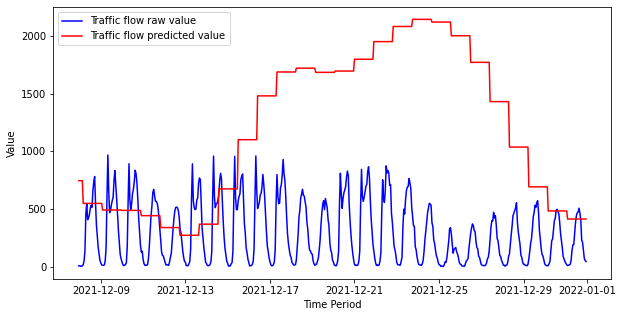

In [ ]:
# Plot predictions

plt.figure(figsize=(10,5))
plt.plot(tsdata_test.df.ds[18695:],test_data[['y']].values[18695:], color='blue', label="Traffic flow raw value")
plt.plot(tsdata_test.df.ds[18695:],y_pred[['yhat']].values[18695:], color='red', label="Traffic flow predicted value")
plt.xlabel("Time Period")
plt.ylabel("Value")
plt.legend()
plt.show() #18396

## **Evaluate Table**

In [38]:
y_pred['yhat']

0        1768.280961
1        1768.280961
2        1768.280961
3        1768.280961
4        1768.280961
            ...     
19267     412.194486
19268     412.194486
19269     412.194486
19270     412.194486
19271     412.194486
Name: yhat, Length: 19272, dtype: float64

In [40]:
test_data['pred'] = list(y_pred['yhat'])
test_data

,id,ds,y,irain,rain,itemp,temp,iwb,wetb,dewpt,...,GL3,1283,1258,1256,weekday,weekend,lat,long,holiday,pred
173448,000000001253A,2021-11-25 12:00:00,3110,0,0.0,0,5.4,0,4.0,2.0,...,0,0,0,0,3,0,51.87488,-8.44783,0,1768.280961
173470,000000001253A,2021-11-25 13:00:00,3151,0,0.0,0,5.8,0,4.3,2.0,...,0,0,0,0,3,0,51.87488,-8.44783,0,1768.280961
173492,000000001253A,2021-11-25 14:00:00,3067,0,0.0,0,6.1,0,4.3,1.6,...,0,0,0,0,3,0,51.87488,-8.44783,0,1768.280961
173514,000000001253A,2021-11-25 15:00:00,3491,0,0.0,0,6.0,0,4.3,1.9,...,0,0,0,0,3,0,51.87488,-8.44783,0,1768.280961
173536,000000001253A,2021-11-25 16:00:00,3594,0,0.0,0,5.5,0,3.9,1.5,...,0,0,0,0,3,0,51.87488,-8.44783,0,1768.280961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192631,000000020223B,2021-12-31 19:00:00,210,0,0.4,0,11.6,0,11.6,11.5,...,0,0,0,0,4,0,51.88714,-8.56911,0,412.194486
192653,000000020223B,2021-12-31 20:00:00,139,0,0.3,0,11.6,0,11.5,11.4,...,0,0,0,0,4,0,51.88714,-8.56911,0,412.194486
192675,000000020223B,2021-12-31 21:00:00,69,2,0.0,0,11.4,0,11.2,11.1,...,0,0,0,0,4,0,51.88714,-8.56911,0,412.194486
192697,000000020223B,2021-12-31 22:00:00,52,2,0.0,0,11.1,0,10.9,10.8,...,0,0,0,0,4,0,51.88714,-8.56911,0,412.194486


In [41]:
list_id = ['000000001253A',
 '000000001253B',
 '000000001255A',
 '000000001255B',
 '000000001256A',
 '000000001256B',
 '000000001258A',
 '000000001258B',
 '000000001271A',
 '000000001271B',
 '000000001283A',
 '000000001283B',
 '000000001401A',
 '000000001401B',
 '000000001403A',
 '000000001403B',
 '000000001404A',
 '000000001404B',
 '000000001405A',
 '000000001405B',
 '000000020223A',
 '000000020223B']
result = pd.DataFrame()
for i in list_id:
  df_filter = test_data[test_data['id'] == i].iloc[50:,:]
  result = pd.concat([result, df_filter])

result.to_csv("/content/drive/MyDrive/Courses/Khoá luận tốt nghiệp/Notebook/Notebook Model/Compare Model/Result_Forecaster_Prophet.csv", index=False)
result

,id,ds,y,irain,rain,itemp,temp,iwb,wetb,dewpt,...,GL3,1283,1258,1256,weekday,weekend,lat,long,holiday,pred
174548,000000001253A,2021-11-27 14:00:00,3395,0,0.0,0,5.1,0,2.7,-1.5,...,0,0,0,0,5,1,51.87488,-8.44783,0,2061.887884
174570,000000001253A,2021-11-27 15:00:00,3174,0,0.0,0,4.7,0,2.5,-1.4,...,0,0,0,0,5,1,51.87488,-8.44783,0,2061.887884
174592,000000001253A,2021-11-27 16:00:00,3312,0,0.0,0,4.2,0,2.3,-1.0,...,0,0,0,0,5,1,51.87488,-8.44783,0,2061.887884
174614,000000001253A,2021-11-27 17:00:00,2785,0,0.0,0,3.5,0,1.9,-1.0,...,0,0,0,0,5,1,51.87488,-8.44783,0,2061.887884
174636,000000001253A,2021-11-27 18:00:00,2225,3,0.0,0,3.0,0,1.5,-1.3,...,0,0,0,0,5,1,51.87488,-8.44783,0,2061.887884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192631,000000020223B,2021-12-31 19:00:00,210,0,0.4,0,11.6,0,11.6,11.5,...,0,0,0,0,4,0,51.88714,-8.56911,0,412.194486
192653,000000020223B,2021-12-31 20:00:00,139,0,0.3,0,11.6,0,11.5,11.4,...,0,0,0,0,4,0,51.88714,-8.56911,0,412.194486
192675,000000020223B,2021-12-31 21:00:00,69,2,0.0,0,11.4,0,11.2,11.1,...,0,0,0,0,4,0,51.88714,-8.56911,0,412.194486
192697,000000020223B,2021-12-31 22:00:00,52,2,0.0,0,11.1,0,10.9,10.8,...,0,0,0,0,4,0,51.88714,-8.56911,0,412.194486


In [63]:
# EVALUATE with Sklearn metric
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
def s_mape(a, f):
  return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))
    # return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

rmse = mean_squared_error(result['y'].to_numpy(), result['pred'].to_numpy(), squared=False)
mae = mean_absolute_error(result['y'].to_numpy(), result['pred'].to_numpy())
mape = mean_absolute_percentage_error(result['y'].to_numpy(), result['pred'].to_numpy())
smape = s_mape(result['y'].to_numpy(), result['pred'].to_numpy())

print("Kết quả dự đoán trên tập test đã cắt 50 dòng mỗi sensor:")
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)
print('sMAPE:', smape)

Kết quả dự đoán trên tập test đã cắt 50 dòng mỗi sensor:
RMSE: 1172.8513686291667
MAE: 962.3089247213893
MAPE: 7.420486063970614e+16
sMAPE: 1.0349374184510975
